In [542]:
# Initial Setup
import pandas as pd
import numpy as np
import re

# datavis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno

from pathlib import Path
from scipy import stats
import os
import io

In [543]:
from utils import *

In [544]:
# set up graphing defaults to look pretty
sns.set_palette('pastel')
sns.set_theme(rc={'axes.facecolor':'lightgrey'})

# Formula One Data Analysis
Ultimate goal: build a model that will predict which constructor will win the race, given the data we have

## Data Cleaning/Wrangling

In [545]:
# Data taken from this kaggle dataset: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
dfs = {dir[:-4]:pd.read_csv(Path('Data') / dir) for dir in os.listdir('Data')}
circuits = dfs['circuits']
constructor_results = dfs['constructor_results']
constructor_standings = dfs['constructor_standings']
constructors = dfs['constructors']
driver_standings = dfs['driver_standings']
drivers = dfs['drivers']
lap_times = dfs['lap_times']
pit_stops = dfs['pit_stops']
qualifying = dfs['qualifying']
races = dfs['races']
results = dfs['results']
seasons = dfs['seasons']
sprint_results = dfs['sprint_results']
status = dfs['status']

### Circuits
`'circuits'` contains info about the tracks (circuits) on which the races were held. It includes latitude/longitude, altitude, and country for each circuit that was raced on from 1950 - 2024.

In [546]:
circuits.head(3)

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.9680,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.7380,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.5106,7,http://en.wikipedia.org/wiki/Bahrain_Internati...


In [547]:
circuits['alt'].unique()

array(['10', '18', '7', '109', '130', '13', '228', '153', '103', '264',
       '4', '401', '162', '583', '5', '785', '223', '578', '37', '45',
       '\\N', '3', '8', '266', '58', '1460', '88', '2227', '345', '432',
       '0', '1126', '177', '145', '6', '36', '484', '139', '12', '639',
       '609', '485', '332', '79', '790', '214', '81', '67', '15', '676',
       '20', '28', '470', '53', '158', '19', '129', '551', '85', '194',
       '161', '678', '2', '-7', '108', '255'], dtype=object)

This is pretty clean already. It just looks like altitude has some `NaN`'s represented as '\\N'. Let's replace those with actual `NaN`.

In [548]:
circuits['alt'] = circuits['alt'].replace('\\N', np.NaN)
circuits['alt'].unique()

array(['10', '18', '7', '109', '130', '13', '228', '153', '103', '264',
       '4', '401', '162', '583', '5', '785', '223', '578', '37', '45',
       nan, '3', '8', '266', '58', '1460', '88', '2227', '345', '432',
       '0', '1126', '177', '145', '6', '36', '484', '139', '12', '639',
       '609', '485', '332', '79', '790', '214', '81', '67', '15', '676',
       '20', '28', '470', '53', '158', '19', '129', '551', '85', '194',
       '161', '678', '2', '-7', '108', '255'], dtype=object)

We probably won't be using the urls from this dataset, so let's just drop those and finish up our cleaning.

In [549]:
circuits = circuits.drop('url', axis=1)

In [550]:
circuits.head(3)

,circuitId,circuitRef,name,location,country,lat,lng,alt
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.9680,10
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.7380,18
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.5106,7


### Constructor Results

In [551]:
constructor_results.head()

,constructorResultsId,raceId,constructorId,points,status
0,1,18,1,14.0,\N
1,2,18,2,8.0,\N
2,3,18,3,9.0,\N
3,4,18,4,5.0,\N
4,5,18,5,2.0,\N


In [552]:
constructor_results['status'].unique()

array(['\\N', 'D'], dtype=object)

The 'status' column seems to be entirely misssing, so let's just save the headache and drop it.

In [553]:
constructor_results[constructor_results['status'] == 'D']

,constructorResultsId,raceId,constructorId,points,status
185,186,36,1,14.0,D
195,196,37,1,18.0,D
207,208,38,1,12.0,D
218,219,39,1,14.0,D
228,229,40,1,18.0,D
239,240,41,1,12.0,D
250,251,42,1,18.0,D
262,263,43,1,8.0,D
273,274,44,1,14.0,D
283,284,45,1,10.0,D


### Constructors
`'constructors'` has data on the constructors, or teams. This includes their names, reference tags, and nationalities.

In [554]:
constructors

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
...,...,...,...,...,...
206,209,manor,Manor Marussia,British,http://en.wikipedia.org/wiki/Manor_Motorsport
207,210,haas,Haas F1 Team,American,http://en.wikipedia.org/wiki/Haas_F1_Team
208,211,racing_point,Racing Point,British,http://en.wikipedia.org/wiki/Racing_Point_F1_Team
209,213,alphatauri,AlphaTauri,Italian,http://en.wikipedia.org/wiki/Scuderia_AlphaTauri


In [555]:
# Cleaning
constructors = constructors.drop(['url'], axis=1) # no \N's this time!
constructors

,constructorId,constructorRef,name,nationality
0,1,mclaren,McLaren,British
1,2,bmw_sauber,BMW Sauber,German
2,3,williams,Williams,British
3,4,renault,Renault,French
4,5,toro_rosso,Toro Rosso,Italian
...,...,...,...,...
206,209,manor,Manor Marussia,British
207,210,haas,Haas F1 Team,American
208,211,racing_point,Racing Point,British
209,213,alphatauri,AlphaTauri,Italian


### Drivers
`'drivers'` contains the mappings for each driver, including their unique reference tags, codes, and names/surnames.

In [556]:
drivers

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
...,...,...,...,...,...,...,...,...,...
852,854,mick_schumacher,47,MSC,Mick,Schumacher,1999-03-22,German,http://en.wikipedia.org/wiki/Mick_Schumacher
853,855,zhou,24,ZHO,Guanyu,Zhou,1999-05-30,Chinese,http://en.wikipedia.org/wiki/Zhou_Guanyu
854,856,de_vries,21,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries
855,857,piastri,81,PIA,Oscar,Piastri,2001-04-06,Australian,http://en.wikipedia.org/wiki/Oscar_Piastri


In [557]:
# Cleaning
drivers = (drivers
           .replace('\\N', np.NaN)
           .drop(['url'], axis=1))
drivers

,driverId,driverRef,number,code,forename,surname,dob,nationality
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British
1,2,heidfeld,NaN,HEI,Nick,Heidfeld,1977-05-10,German
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish
4,5,kovalainen,NaN,KOV,Heikki,Kovalainen,1981-10-19,Finnish
...,...,...,...,...,...,...,...,...
852,854,mick_schumacher,47,MSC,Mick,Schumacher,1999-03-22,German
853,855,zhou,24,ZHO,Guanyu,Zhou,1999-05-30,Chinese
854,856,de_vries,21,DEV,Nyck,de Vries,1995-02-06,Dutch
855,857,piastri,81,PIA,Oscar,Piastri,2001-04-06,Australian


Let's combine `'forename'` and `'surname'` into just `'name'`

In [558]:
drivers['name'] = drivers['forename'] + ' ' +  drivers['surname']
drivers = drivers.drop(['forename', 'surname'], axis=1)
drivers

,driverId,driverRef,number,code,dob,nationality,name
0,1,hamilton,44,HAM,1985-01-07,British,Lewis Hamilton
1,2,heidfeld,NaN,HEI,1977-05-10,German,Nick Heidfeld
2,3,rosberg,6,ROS,1985-06-27,German,Nico Rosberg
3,4,alonso,14,ALO,1981-07-29,Spanish,Fernando Alonso
4,5,kovalainen,NaN,KOV,1981-10-19,Finnish,Heikki Kovalainen
...,...,...,...,...,...,...,...
852,854,mick_schumacher,47,MSC,1999-03-22,German,Mick Schumacher
853,855,zhou,24,ZHO,1999-05-30,Chinese,Guanyu Zhou
854,856,de_vries,21,DEV,1995-02-06,Dutch,Nyck de Vries
855,857,piastri,81,PIA,2001-04-06,Australian,Oscar Piastri


### Races
The `'races'` dataframe contains info about each race, including the circuit, date, and time. The `'fp'` columns contain the dates and times of the Free Practices.

In [559]:
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


The changes in the [point system](https://en.wikipedia.org/wiki/List_of_Formula_One_World_Championship_points_scoring_systems) will be very difficult to deal with... and older races won't really help us in prediction anyways. I'm making the executive decision to drop all races before 1991; This'll give us more modern statistics, and we won't have to deal with (as many) changes in how points are scored.

In [560]:
# Storing in a different variable
races_1991 = races[races['year'] >= 1991]
races_1991.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [561]:
races_1991.shape

(601, 18)

In [562]:
races_1991['year'].describe()

count     601.000000
mean     2007.893511
std         9.553986
min      1991.000000
25%      2000.000000
50%      2008.000000
75%      2016.000000
max      2023.000000
Name: year, dtype: float64

We'll be merging on `'races_1991'` going forward, so we won't need to drop any rows in other dataframes (hopefully).

Now let's combine `'date'` and `'time'` to get a single column of Timestamp objects with the date and the time. We'll do this for all the columns that are formatted similarly.

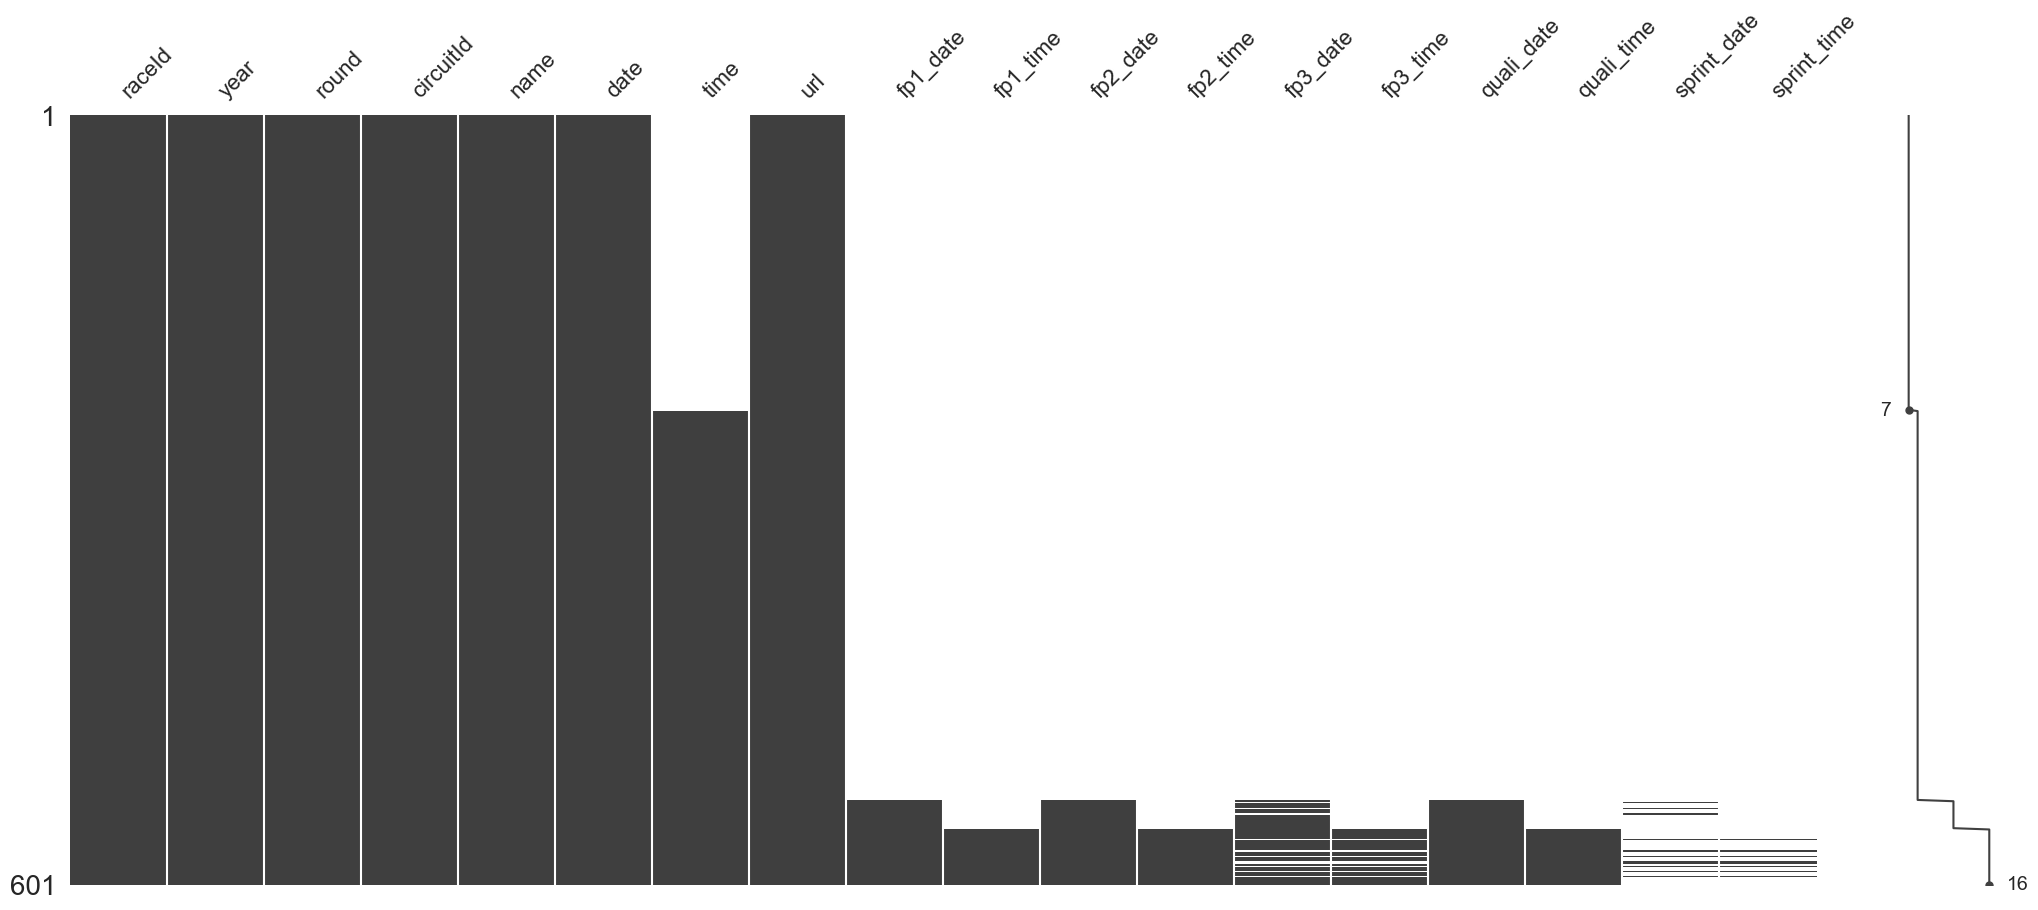

In [563]:
# filling nan values
races_1991 = (races_1991
              .replace('\\N', np.nan)
              .sort_values('year')
              )
missingno.matrix(races_1991);

A big chunk of our times are missing. We should fix this before moving on, so we're not just naively filling values.

In [564]:
plot_missing_diff(races_1991, 'time', 'year')

So, the earlier years are apparently missing times. My guess is they only started recording times in 2005. This makes the data NMAR, meaning we can't really resolve this easily without knowing the actual times. For now, let's just fill them with randomly sampled values from the existing times.

In [565]:
num_na = races_1991['time'].isna().sum()
races_1991['time'][races_1991['time'].isna()] = np.random.choice(races_1991[~races_1991['time'].isna()]['time'], size=num_na)

/var/folders/sj/59v4c3dd1r1brq_2d_bjy80w0000gn/T/ipykernel_3623/3392402823.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [566]:
to_drop = ['url', 'year']
for col in races_1991:
    if 'date' in col.lower():
        prefix = re.findall('\w+_', col)
        prefix = prefix[0] if prefix else ''
        date_col = prefix + 'date'
        time_col = prefix + 'time'
        dates = pd.to_datetime(races_1991[date_col])
        times = pd.to_timedelta(races_1991[time_col])
        # fill nan values for time with probabilistic imputation
        times[times.isna()] = np.random.choice(times[~times.isna()], size=times[times.isna()].size)
        races_1991[date_col] = dates + times
        to_drop.append(time_col)
races_1991 = races_1991.drop(to_drop, axis=1)
races_1991

,raceId,round,circuitId,name,date,fp1_date,fp2_date,fp3_date,quali_date,sprint_date
305,306,2,18,Brazilian Grand Prix,1991-03-24 12:00:00,NaT,NaT,NaT,NaT,NaT
304,305,1,33,United States Grand Prix,1991-03-10 12:00:00,NaT,NaT,NaT,NaT,NaT
306,307,3,21,San Marino Grand Prix,1991-04-28 14:00:00,NaT,NaT,NaT,NaT,NaT
307,308,4,6,Monaco Grand Prix,1991-05-12 07:00:00,NaT,NaT,NaT,NaT,NaT
308,309,5,7,Canadian Grand Prix,1991-06-02 18:00:00,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
1080,1099,2,77,Saudi Arabian Grand Prix,2023-03-19 17:00:00,2023-03-17 13:30:00,2023-03-17 17:00:00,2023-03-18 13:30:00,2023-03-18 17:00:00,NaT
1079,1098,1,3,Bahrain Grand Prix,2023-03-05 15:00:00,2023-03-03 11:30:00,2023-03-03 15:00:00,2023-03-04 11:30:00,2023-03-04 15:00:00,NaT
1099,1119,21,80,Las Vegas Grand Prix,2023-11-19 06:00:00,2023-11-17 04:30:00,2023-11-17 08:00:00,2023-11-18 04:30:00,2023-11-18 08:00:00,NaT
1088,1108,10,9,British Grand Prix,2023-07-09 14:00:00,2023-07-07 11:30:00,2023-07-07 15:00:00,2023-07-08 10:30:00,2023-07-08 14:00:00,NaT


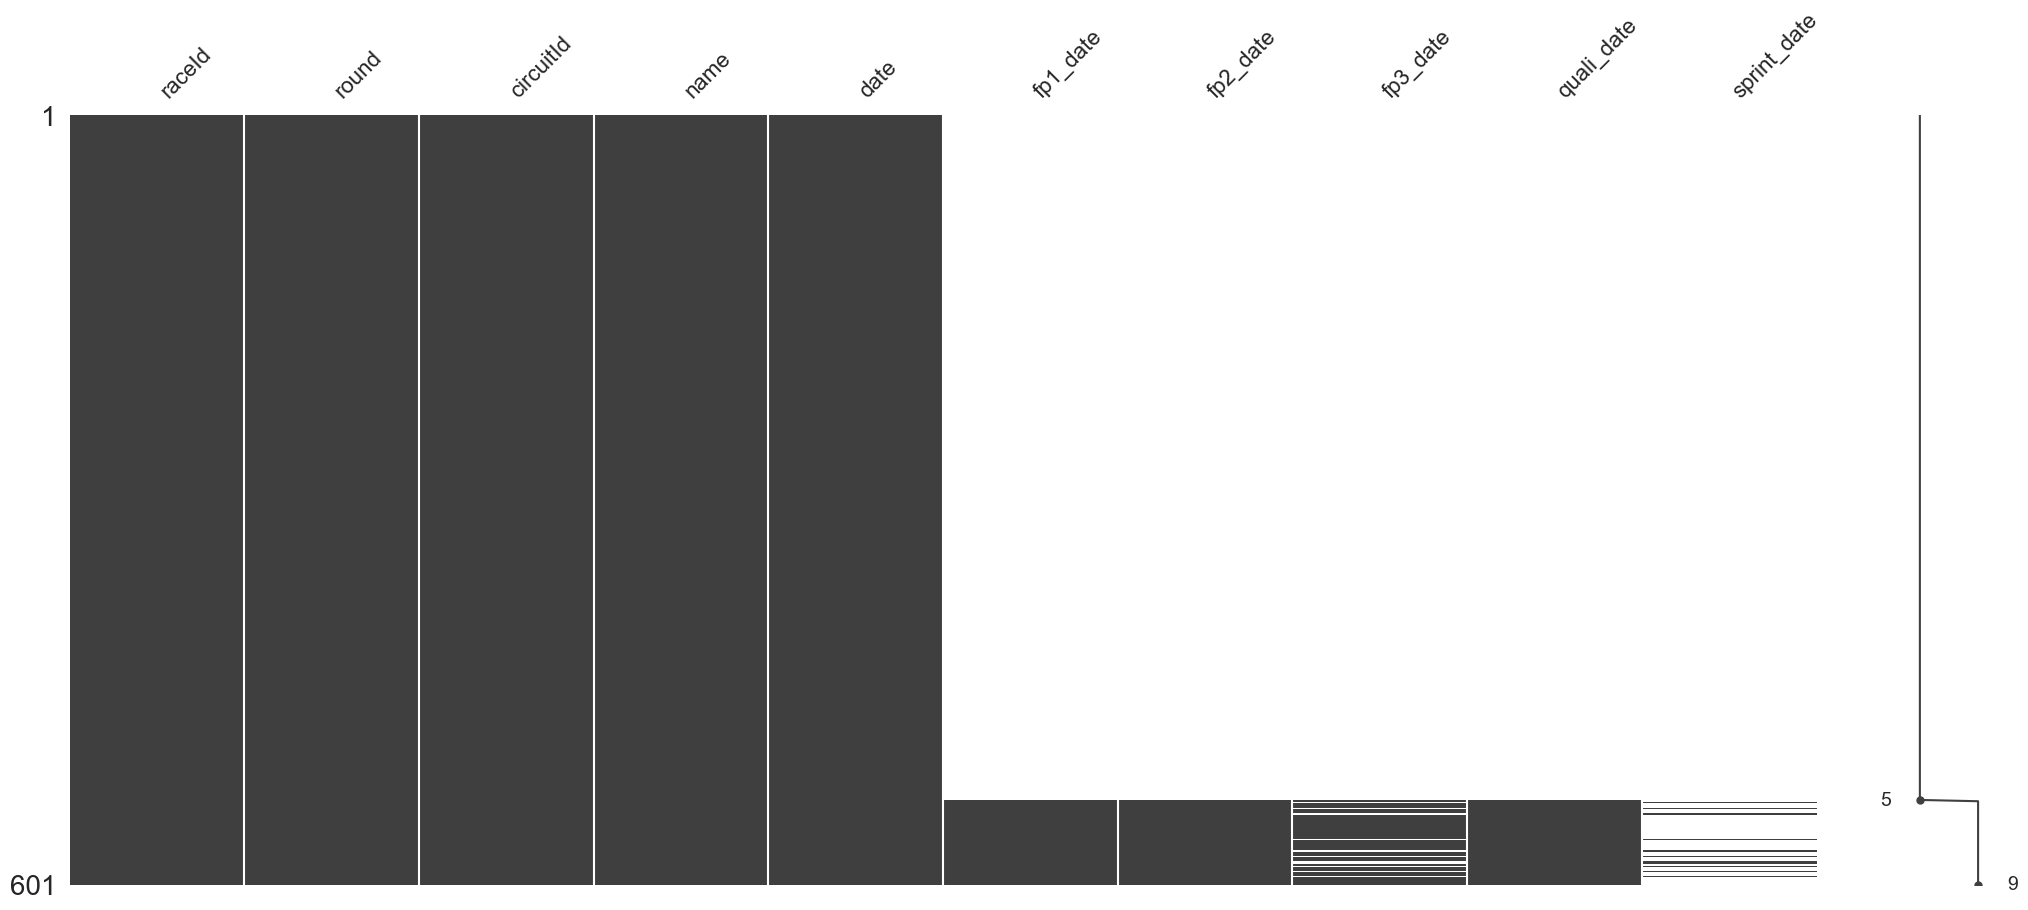

In [567]:
missingno.matrix(races_1991);

### Results
The `'results'` dataframe has the meat of our data: The results of each race, for each driver. This includes car number for each driver (`'number'`), position in the starting grid (`'grid'`), final position (`'position'`), final rank (`'positionOrder'`), and data on lap speeds. Speeds are (probably) in km/h.

For `'position text'`, the values are as follows:
- Any integer: finishing position
- `R`: retired
- `D`: disqualified
- `E`: excluded
- `W`: withdrawn
- `F`: failed to qualify
- `N`: not classified

In [568]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


Taking a look at this dataset, the null values are also represented with '\N', so we'll replace those with proper NaNs.

In [569]:
results = results.replace('\\N', np.NaN)

Since we have the data for their final times in milliseconds, we don't really need the `'time'` column - it's just giving us the same data, but is harder to work with due to its inconsistent formatting. Let's drop it.

In [570]:
results = results.drop('time', axis=1)
results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,5708630,43,1,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26075,26081,1110,817,213,3,19,16,16,16,0.0,44,5053521,25,15,1:50.994,227.169,1
26076,26082,1110,858,3,2,18,17,17,17,0.0,44,5054926,37,9,1:50.486,228.213,1
26077,26083,1110,807,210,27,0,18,18,18,0.0,44,5060900,26,4,1:49.907,229.415,1
26078,26084,1110,832,6,55,4,NaN,R,19,0.0,23,NaN,9,19,1:53.138,222.864,130


### Sprint Results
[Sprints](https://www.formula1.com/en/latest/article.explained-everything-you-need-to-know-about-the-2023-f1-sprint-format.583WHWKbWVVBemPKi6pJxH.html) are shorter, '100km dash' events, with no pit stops, designed to test the drivers' aggressiveness. Winners get 8 points (since 2022). While this data is only available for races post-2021, it might still prove useful.

In [571]:
sprint_results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,25:38.426,1538426,14,1:30.013,1
1,2,1061,1,131,44,1,2,2,2,2,17,+1.430,1539856,17,1:29.937,1
2,3,1061,822,131,77,3,3,3,3,1,17,+7.502,1545928,17,1:29.958,1
3,4,1061,844,6,16,4,4,4,4,0,17,+11.278,1549704,16,1:30.163,1
4,5,1061,846,1,4,6,5,5,5,0,17,+24.111,1562537,16,1:30.566,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,1110,858,3,2,13,16,16,16,0,11,+37.571,1536004,6,2:03.482,1
176,177,1110,807,210,27,20,17,17,17,0,11,+37.827,1536260,6,2:03.472,1
177,178,1110,852,213,22,16,18,18,18,0,11,+39.267,1537700,7,2:02.080,1
178,179,1110,815,9,11,8,\N,R,19,0,8,\N,\N,2,2:02.516,130


In [572]:
# Cleaning
sprint_results = (sprint_results
                  .drop(['time'], axis=1) # time is repeated data
                  .replace('\\N', np.NaN) # filling null values with actual NaN
                  )
sprint_results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,1538426,14,1:30.013,1
1,2,1061,1,131,44,1,2,2,2,2,17,1539856,17,1:29.937,1
2,3,1061,822,131,77,3,3,3,3,1,17,1545928,17,1:29.958,1
3,4,1061,844,6,16,4,4,4,4,0,17,1549704,16,1:30.163,1
4,5,1061,846,1,4,6,5,5,5,0,17,1562537,16,1:30.566,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,1110,858,3,2,13,16,16,16,0,11,1536004,6,2:03.482,1
176,177,1110,807,210,27,20,17,17,17,0,11,1536260,6,2:03.472,1
177,178,1110,852,213,22,16,18,18,18,0,11,1537700,7,2:02.080,1
178,179,1110,815,9,11,8,NaN,R,19,0,8,NaN,2,2:02.516,130


### Status
the `'status'` dataframe contains mappings of statuses for race results. These might be useful, but there's not much cleaning to be done here.

In [573]:
status

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
...,...,...
134,137,Damage
135,138,Debris
136,139,Illness
137,140,Undertray


## Putting it All Together
We have all this useful information separated into different dataframes. Let's put all of it together, so that we can get a single, full dataframe, with all the info from the dataframes of interest. The endgoal is to have a dataframe with only a single "id" column, and data on the constructors, drivers, circuit, races, and race results. This dataframe will have one row for each driver for each race (similar to the results dataframe).

We'll start with the results dataframe, and go from there.

In [574]:
results

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,5708630,43,1,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26075,26081,1110,817,213,3,19,16,16,16,0.0,44,5053521,25,15,1:50.994,227.169,1
26076,26082,1110,858,3,2,18,17,17,17,0.0,44,5054926,37,9,1:50.486,228.213,1
26077,26083,1110,807,210,27,0,18,18,18,0.0,44,5060900,26,4,1:49.907,229.415,1
26078,26084,1110,832,6,55,4,NaN,R,19,0.0,23,NaN,9,19,1:53.138,222.864,130


In [575]:
# add in names of drivers and constructors
results_with_names = (results
                      .merge(drivers, on='driverId', how='left', suffixes=('_res', '_dr')) # left merging, so we keep the races with unknown drivers if there are any
                      .merge(constructors, on='constructorId', how='left', suffixes=('_dr', '_con')) # same deal
                      ) 

In [576]:
# add in race data
results_races = results_with_names.merge(races_1991, on='raceId', how='inner') # inner merge because we only want races past 1991, and results that exist

In [577]:
# adding in circuits data
races_circuits = results_races.merge(circuits, on='circuitId', how='left', suffixes=('_race', '_circ'))

In [578]:
# add in statuses
races_full = races_circuits.merge(status, on='statusId')
races_full.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number_res', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'driverRef', 'number_dr', 'code', 'dob',
       'nationality_dr', 'name_dr', 'constructorRef', 'name_con',
       'nationality_con', 'round', 'circuitId', 'name_race', 'date',
       'fp1_date', 'fp2_date', 'fp3_date', 'quali_date', 'sprint_date',
       'circuitRef', 'name_circ', 'location', 'country', 'lat', 'lng', 'alt',
       'status'],
      dtype='object')

In [579]:
# drop columns with 'Id'
id_cols = [col for col in races_full.columns if 'Id' in col]
races_full.drop(id_cols, axis=1)

,number_res,grid,position,positionText,positionOrder,points,laps,milliseconds,fastestLap,rank,...,quali_date,sprint_date,circuitRef,name_circ,location,country,lat,lng,alt,status
0,22,1,1,1,1,10.0,58,5690616,39,2,...,NaT,NaT,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.96800,10,Finished
1,3,5,2,2,2,8.0,58,5696094,41,3,...,NaT,NaT,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.96800,10,Finished
2,7,7,3,3,3,6.0,58,5698779,41,5,...,NaT,NaT,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.96800,10,Finished
3,5,11,4,4,4,5.0,58,5707797,58,7,...,NaT,NaT,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.96800,10,Finished
4,23,3,5,5,5,4.0,58,5708630,43,1,...,NaT,NaT,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.96800,10,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13103,9,20,NaN,W,20,0.0,0,NaN,NaN,0,...,2021-12-11 20:00:00,NaT,yas_marina,Yas Marina Circuit,Abu Dhabi,UAE,24.4672,54.60310,3,Illness
13104,77,8,NaN,R,15,0.0,36,NaN,31,14,...,2022-03-26 17:00:00,NaT,jeddah,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.6319,39.10440,15,Cooling system
13105,14,7,NaN,R,16,0.0,35,NaN,33,12,...,2022-03-26 17:00:00,NaT,jeddah,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.6319,39.10440,15,Water pump
13106,6,17,NaN,R,19,0.0,48,NaN,14,19,...,2022-07-08 15:00:00,2022-07-09 14:30:00,red_bull_ring,Red Bull Ring,Spielberg,Austria,47.2197,14.76470,678,Undertray
